# Digit Recognizer
Classify digits from the MNIST data set using logistic regression. 

In [1]:
# packages to import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

%matplotlib inline

In [63]:
# read in data using pandas
df_train = pd.read_csv('train.csv')

In [64]:
# split (training) data into training and testing sets
def split_data(df, fraction=0.9): 
    # get pixels and labels
    pixels = df.iloc[:,1:785].as_matrix()
    labels = df.iloc[:,0].as_matrix()
    
    # normalize data
    pixels = pixels / 255.0
    #pixels = pixels / np.sum(pixels, axis=1)[:,None]
    
    # add column that is just ones for offset
    pixels = np.c_[pixels, np.ones(len(pixels))]
    
    # split into training and testing
    n = pixels.shape[0]
    pixels_train = pixels[0:int(fraction * n)]
    pixels_test = pixels[int(fraction * n):n]
    labels_train = labels[0:int(fraction * n)]
    labels_test = labels[int(fraction * n):n]
    
    return pixels_train, pixels_test, labels_train, labels_test

In [54]:
# first we train on 80% of the data and test on 10% to check that algorithm is coded correctly
X_train, X_test, y_train, y_test = split_data(df_train, fraction=0.8)

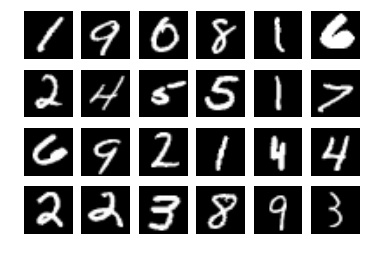

In [5]:
# make plot to see what the numbers look like
plt.figure()
for i in range(0,24):
    image = X_train[i*100,0:784]
    image = np.reshape(image, [28,28])
    plt.subplot(4,6,i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')


## Logistic regression
Logistic regression uses the sigmoid function
$$h(x) = \dfrac{1}{1+exp(-\theta^T x)}$$
In the binary case, we have that
$$p(y=1 | x; \theta) = h(x) \\
p(y=0 | x; \theta) = 1 - h(x) $$
and 
$$p(y | x; \theta) = h(x)^y(1-h(x))^{1-y})$$
The likelihood is then 
$$\mathcal{L}(\theta) = \prod_{i=1}^m p(y_i|x_i,\theta) = \prod_{i=1}^m h(x_i)^{y_i} (1-h(x_i))^{1-y_i}$$
and the log-likelihood is 
$$\mathcal{l}(\theta) = \sum_{i=1}^m y_i\log h(x_i) + (1-y_i)\log(1-h(x_i))$$
In the case where we have more than two classes, we can use the categorical distribution. A simpler way to think about it, however, is to continue using the two class formulation but repeat it for every digit so that each image ends up with 10 classifications. If an image classifies as true for more than one number, the one with the highest value is chosen. 

To get the parameters, we find the maximum likelihood estimate by computing the derivative and setting it to zero, keeping in mind that the derivative of the sigmoid $g(z)$ is $g(z)(1-g(z))$. 
$$\begin{align*}\dfrac{\partial}{\partial \theta} \mathcal{l}(\theta) &= \dfrac{\partial}{\partial \theta} \sum_{i=1}^m y_i \log h(x_i) + (1-y_i) \log (1 - h(x_i)) \\
&= \dfrac{\partial}{\partial \theta} \sum_{i=1}^m y_i \log \left(\dfrac{h(x_i)}{1-h(x_i)}\right) + \log (1 - h(x_i)) \\
&= \dfrac{\partial}{\partial \theta} \sum_{i=1}^m y_i \theta^Tx_i - \log(1 + h(x_i)) \\
&= \sum_{i=1}^m y_i x_i^T - h(x_i)x_i^T\end{align*}$$

In [55]:
# sigmoid function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1.0*x))

# the log-likelihood, which is our objective function
def log_likelihood(X,y,theta):
    n_entries = X.shape[0]
    n_pixels = X.shape[1]
    ll = 0
    for i in range(0,n_entries):
        h = sigmoid(np.dot(X[i,:], theta))
        ll += y[i] * np.log(h) + (1-y[i]) * np.log(1 - h)
      
    return ll

# the derivative of the log likelihood which some optimizers need
def jacobian(X, y, theta):
    n_entries = X.shape[0]
    n_pixels = X.shape[1]
    j = np.zeros(n_pixels)
    for i in range(0, n_entries):
        j += y[i] * X[i,:] - sigmoid(np.dot(X[i,:], theta)) * X[i,:]
    
    return j

In [58]:
# use optimization to get parameters for all digits
def compute_all_thetas(log_likelihood, jacobian, initial_guess, num_iter):
    Theta = np.zeros([10, 785])

    for i in range(0,10):
        print('i = ', i)
        objective_function = lambda theta: -1.0*log_likelihood(X_train, y_train == i, theta)
        jac = lambda theta: -1.0 * jacobian(X_train, y_train == i, theta)
        res = minimize(objective_function, initial_guess, jac=jac, method='L-BFGS-B', options={'maxiter' : num_iter, 'disp' : True})
        Theta[i] = res.x
        
    return Theta

In [60]:
Theta = compute_all_thetas(log_likelihood, jacobian, np.zeros(785), 10)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [61]:
# classify digits based on the index with the higest value
def classify(X, Theta):
    index = np.argmax(np.dot(Theta,np.transpose(X)), axis=0)
    return index

# computes number of mis-classifications
def compute_misclassifications(X, y, Theta):
    pred = classify(X, Theta)
    return np.sum(pred != y)

In [62]:
# compute percente error on training and test sets
percent_error_training = compute_misclassifications(X_train, y_train, Theta) / X_train.shape[0]
percent_error_test = compute_misclassifications(X_test, y_test, Theta) / X_test.shape[0]
print('The error on the training set is: %s \nThe error on the test set is : %s' 
      %(percent_error_training, percent_error_test))

The error on the training set is: 0.0915476190476 
The error on the test set is : 0.0941666666667


In [65]:
# it looks like the algorithm is doing okay, so let's run the optimization for longer on the complete training set
X_train, X_test, y_train, y_test = split_data(df_train, fraction=1.0)
Theta = compute_all_thetas(log_likelihood, jacobian, np.zeros(785), 500)

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


In [66]:
# check error on training data
percent_error_training = compute_misclassifications(X_train, y_train, Theta) / X_train.shape[0]
print('Training error: %s' %(percent_error_training))

Training error: 0.0622619047619


In [67]:
# make predictions for test data set
df_test = pd.read_csv('test.csv')

In [68]:
# convert to numpy array and append column of ones
test_pixels = df_test.as_matrix()
test_pixels = np.c_[test_pixels, np.ones(len(test_pixels))]

In [69]:
# make classifications
predictions = classify(test_pixels, Theta)

In [71]:
# convert to dataframe and write out to a text file
df_pred = pd.DataFrame()
df_pred['ImageId'] = range(1,28001)
df_pred['Label'] = predictions
df_pred.to_csv('LogisticRegression.csv', index=False)

In [88]:
# also write out theta to a csv because it took a long time to compute! (and we can use it as initial guess next time)
df_theta = pd.DataFrame(Theta)
df_theta.to_csv('Theta.csv')